Data analysis for the Franck-Hertz experiment

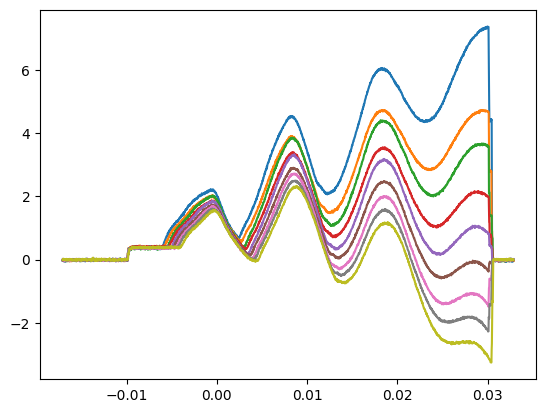

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

avgs = pd.DataFrame()
for m in [6, 65, 7, 75, 8, 85, 9, 95, 10]:

    # read all 5 iterations of the same measurement
    datas_1 = pd.DataFrame(); datas_2 = pd.DataFrame()
    for i in range(0, 5):
        # for channel 1
        data = pd.read_csv(str("data/scov" + str(m) + "_0" + str(i+1) + ".csv"), skiprows = [1])
        datas_1.insert(0, str(i), data["1"])
        datas_2.insert(0, str(i), data["2"])

    # compute mean and sd of the measurements
    res_1 = pd.concat([datas_1.mean(axis = 1), datas_1.std(axis = 1)], axis = 1)
    res_2 = pd.concat([datas_2.mean(axis = 1), datas_2.std(axis = 1)], axis = 1)
    res_m = res_1.join(res_2, lsuffix = "_2")
    res_m.columns = ["mean_1", "sd_1", "mean_2", "sd_2"]
    res_m.insert(0, "finvolt", m)
    
    # combine to one large df for plotting
    if avgs.empty:
        avgs = res_m
    else:
        avgs = pd.concat([avgs, res_m], axis = 0, ignore_index = True)

    # find minima of channel 1
        
    # compute distances between minima
        
    # plot curves
    plt.plot(data["x-axis"], avgs[avgs["finvolt"] == m]["mean_1"])
    

